# MSAI BH Sim Exploration
Members: Jack, Arjun, Ruchi

In [1]:
%load_ext autoreload
%autoreload 2
%run -i harmpi/harm_script.py

In [2]:
from utils.utils import read_dump_util

# NOTE read_dump_util replaces rd('dump000') for msai code

dump_name = 'dump000'
_, dump_dict = read_dump_util(dump=dump_name)
t = dump_dict['t']
print(f'The time associated with {dump_name} is: {t}')

The time associated with dump000 is: 0.0


In [3]:
# reads all dumps in file system
import os
import re

dumps = []
for filename in os.listdir('harmpi/dumps'):
    if re.match(r'^dump\d+$', filename):
        dumps.append(filename)
dumps.sort()
num_dumps = len(dumps)
print(f'Number of Dumps on disk: {num_dumps}')


Number of Dumps on disk: 29


In [ ]:
# translate dump data into tensors
from utils.data_utils import tensorize_dumps
# turn dumps on disk into single stacked tensor data
data = tensorize_dumps(dumps=dumps, log_non_negs=True)
print(f'Shape of the dataset: {data.shape}')

Shape of the dataset: torch.Size([29, 8, 128, 128])


In [73]:
from utils.data_utils import make_prediction_dataloaders

# make prediction dataloaders
train_loader, val_loader, test_loader = make_prediction_dataloaders(data=data)

Number of parameters: 16912512
Size of model in memory: 64.52 MB


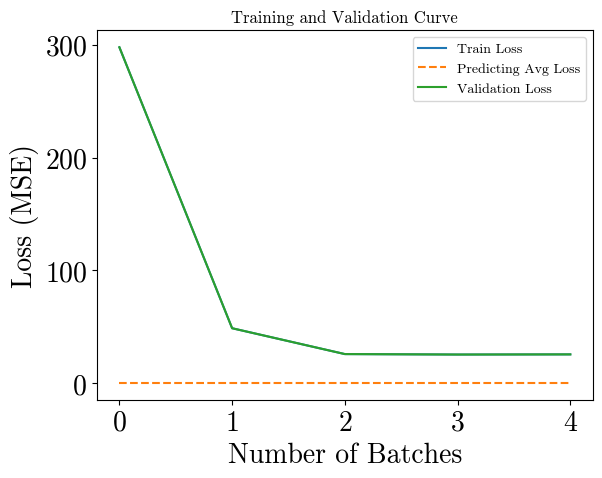

Saved model as models/ffnn/saves/ffnn_v0.0.0.pth


In [7]:
from models.train_model import train_model
from models.ffnn.ffnn import FFNN
import torch

# initialize net
pred_ffnn_net = FFNN(
    version_str = 'v0.0.0',
    input_dim = 8*128*128,
)
print(f'Number of parameters: {pred_ffnn_net.num_params()}')
print(f'Size of model in memory: {pred_ffnn_net.size_in_memory():.2f} MB')


# train net
losses = train_model(
    model = pred_ffnn_net,
    loss_fn = torch.nn.MSELoss(),
    epochs = 5,
    train_loader = train_loader,
    valid_loader = val_loader,
    flatten=True,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
pred_ffnn_net.save()



Number of parameters: 4961571
Size of model in memory: 18.93 MB


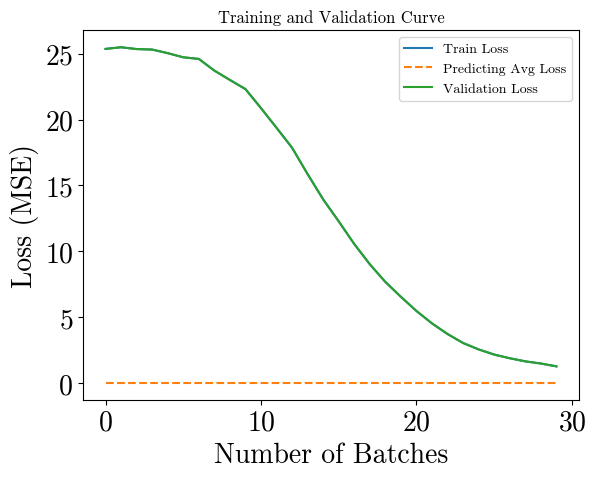

Saved model as models/cnn/saves/pred_cnn_v0.0.0.pth


In [9]:
from models.train_model import train_model
from models.cnn.cnn import CNN, miniCNN

# initialize net
pred_cnn_net = miniCNN(
    name = 'pred_cnn',
    version_str = 'v0.0.0',
    input_channels = 8,
)
# get parameters and memory footprint
print(f'Number of parameters: {pred_cnn_net.num_params()}')
print(f'Size of model in memory: {pred_cnn_net.size_in_memory():.2f} MB')

# train net
losses = train_model(
    model = pred_cnn_net,
    loss_fn = torch.nn.MSELoss(),
    epochs = 30,
    train_loader = train_loader,
    valid_loader = val_loader,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
pred_cnn_net.save()

In [10]:
# load model state dictionary
net = FFNN(input_dim = 8*128*128)
net.load_state_dict(torch.load(f'models/ffnn/saves/ffnn_v0.0.0.pth', weights_only=True))

<All keys matched successfully>

In [76]:
from utils.data_utils import make_encoding_dataloaders

# make encoding dataloaders
train_loader, val_loader = make_encoding_dataloaders(data=data)

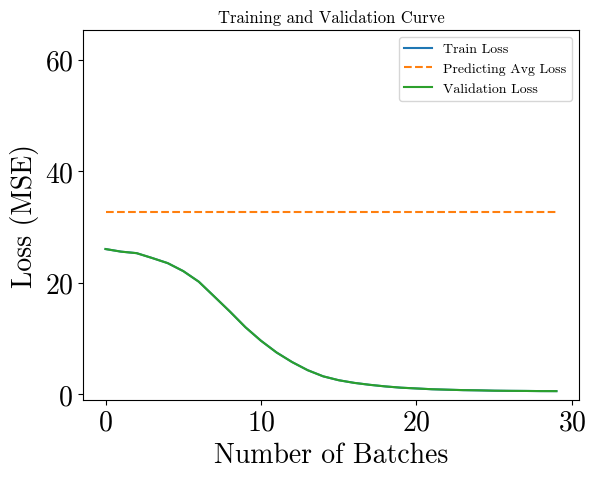

Saved model as models/cnn/saves/ae_cnn_v0.0.0.pth


In [78]:
# train autoencoder
# initialize net
ae_net = miniCNN(
    name = 'ae_cnn',
    version_str = 'v0.0.0',
    input_channels = 8,
)

# train net
losses = train_model(
    model = ae_net,
    loss_fn = torch.nn.MSELoss(),
    epochs = 30,
    train_loader = train_loader,
    valid_loader = val_loader,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
ae_net.save()

In [68]:
# make latent dataset
from utils.data_utils import make_prediction_dataloaders

# encode training data
latents_list = []
for datum in data:
    datum = datum.unsqueeze(0)
    latent = ae_net.encode(datum)
    latents_list.append(latent.detach())
    
# make single tensor of latents
latents = torch.cat(latents_list, dim=0)    

# make prediction dataloaders
train_loader, val_loader, test_loader = make_prediction_dataloaders(data=latents)


Number of parameters: 13899
Size of model in memory: 0.05 MB


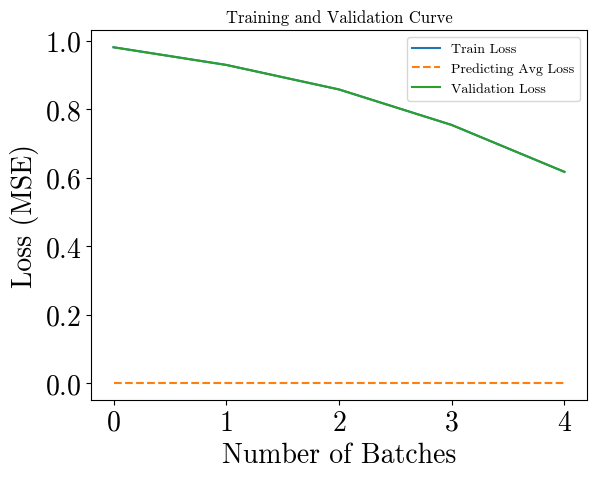

Saved model as models/ffnn/saves/ffnn_v0.0.0.pth


In [69]:
# # train FFNN latent prediction model
from models.train_model import train_model
from models.ffnn.ffnn import FFNN
import torch

# initialize net
latent_net = FFNN(
    version_str = 'v0.0.0',
    input_dim = ae_net.latent_dim,
)
print(f'Number of parameters: {latent_net.num_params()}')
print(f'Size of model in memory: {latent_net.size_in_memory():.2f} MB')


# train net
losses = train_model(
    model = latent_net,
    loss_fn = torch.nn.MSELoss(),
    epochs = 5,
    train_loader = train_loader,
    valid_loader = val_loader,
    flatten=False,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
latent_net.save()

Directory ./movies already exists.
Saved animated dumps at ./movies/latent_movie.gif


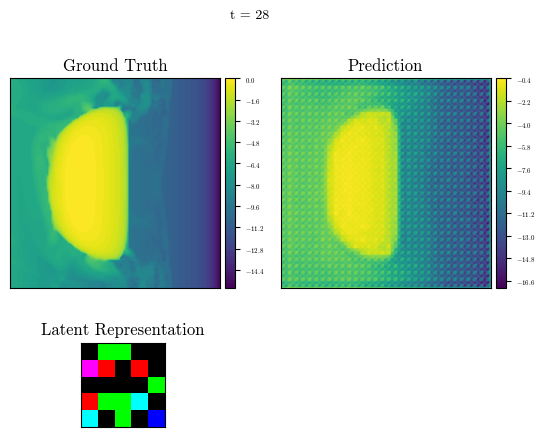

In [70]:
from utils.anim import make_ground_truth_frames, make_prediciton_frames, animate_comparison

# make frames from ground truth data
ground_truths = make_ground_truth_frames(dumps = dumps)

# make frames from recursive prediction
predictions, latents = make_prediciton_frames(
    net=pred_cnn_net,
    first_frame=data[0].unsqueeze(0), 
    make_latents=True,
    num_frames=len(dumps)
    )

# animate
animate_comparison(
    ground_truths = ground_truths, 
    predictions = predictions, 
    latents = latents,
    save_path = './movies/latent_movie.gif',
    cb = True
)

Number of parameters: 292040
Size of model in memory: 1.11 MB


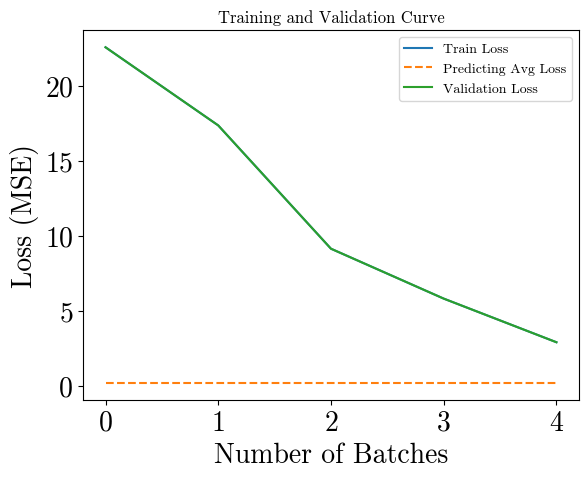

Saved model as models/unet/saves/unet_v0.0.0.pth


In [74]:
# train prediction UNet# 
from models.train_model import train_model
from models.unet.unet import UNet
import torch

# initialize net
pred_unet__net = UNet()
print(f'Number of parameters: {pred_unet__net.num_params()}')
print(f'Size of model in memory: {pred_unet__net.size_in_memory():.2f} MB')


# train net
losses = train_model(
    model = pred_unet__net,
    loss_fn = torch.nn.MSELoss(),
    epochs = 5,
    train_loader = train_loader,
    valid_loader = val_loader,
    flatten=False,
    verbose=False,
    plot_learning_curves=True,
)

# save state dictionary of model
pred_unet__net.save()
# TODO plot UNet
